## Ridge regression
#### In this part of the assignment, we are required to implement Stochastic and batch gradient descents with ridge regression. Ridge regression is basically a weight decay because in sequential learning algorithms, it encourages weight values to decay towards zero, unless supported by the data (i.e., only big enough data should result to more complex model). We implement ridge regression with Stochastic and batch gradient descent as done below.


In [1]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.6.1"

In [2]:
#dfunction to read the data in the desired format
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   
   return (list("x" = x, "y" = y))
    
}


In [3]:
#predict labels based on  weight vectore
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

In [4]:
# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

In [5]:
# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
       #calculate train error 
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
       #calculate test error
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
    #return train and test errors
   return(errors)
}

In [6]:
# implement SGD 
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}




## Weight update for SGD - <br/>
In order to update the weights in SGD, we first require to update the gradient followed by updating the weights. 
The new gradient becomes $$gradient = (matrix(y_true - y_pred)*x) + \lambda*W_{prev}$$
Hence, the weight update becomes $$W_{prev} - eta*gradient$$

In [7]:
# function to update the weights in SGD
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # we update the gradient and weights below as mentioned above
   gradient = matrix(- (y_true-y_pred) * x) +  lambda*W_prev
   return(W_prev - eta * gradient)
}

In [8]:
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]

   W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
   W[1,] <- runif(ncol(train_x))

   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   trainin_size = dim(train_x)[1]
   for (tau in 1:max_epoch){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}

       # make prediction over the training set
       y_pred = train_x %*% W[tau,]

       # update the weight you may decide to chose linea search or not (we are not using line search here)
       W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)

       # keep track of the objective funtion
       obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
       
       
   } 
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}



## Weight update for BGD - 
Below are the steps for updating weights in BGD. For a BGD, since we perform it over the entire data at a go, we take colMeans of the gradient and then multiply it with eta and subtract from the weight. This shown below,
We update gradient as $$gradient= -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x) + lambda*W_prev$$
<br>
so weight update will be $$W_{prev} = - eta * gradient$$

In [9]:
# function to update the weights in BGD
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # update gradient by adding lambda*W_prev and perform the weight update
   gradient = -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x)+ lambda*W_prev
   return (W_prev - eta * gradient)
}

We now the load the dataset, initialize our parameters and the plot the errors.

In [10]:
dtrain = read_data("Task1C_train.csv", TRUE)
dtest = read_data("Task1C_test.csv", TRUE)
 
  
#intialize parameters
   max_epoch = 18
   epsilon = .001
   eta = .01
   lambda=0
    #store weight updates
    options(warn=-1)
 ##### SGD and BGD Trainng

   train_res_sgd = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
    train_res_bgd = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch-1)
    #find error rate for each weight update iteration both test and train errors 
    # column one for test error and column two for training errors
    errors_sgd = get_errors(dtrain, dtest, train_res_sgd$W) # get errors for SGD
    errors_bgd = get_errors(dtrain, dtest, train_res_bgd$W) # get erros for BGD


In [40]:
# create a dataframe to store the errors for BGD,for every N data points one point of BGD
train = read.csv("Task1C_train.csv", TRUE) # we re-read the dataset to get the lenght of the training data
len.train<-nrow(train)
miss<-c()
for( val in errors_bgd[,1])
{
    start <- length(miss)
   end <- start+ len.train
    miss[end]<- val
}

In [41]:
# dataframe to store errors for BGD and SGD
plotdataframe<-data.frame('x'=1:length(miss),'SGD'=errors_sgd[,1],'BGD'=miss )

Below we plot the errors for SGD and BGD on a single plot and compare their errors.

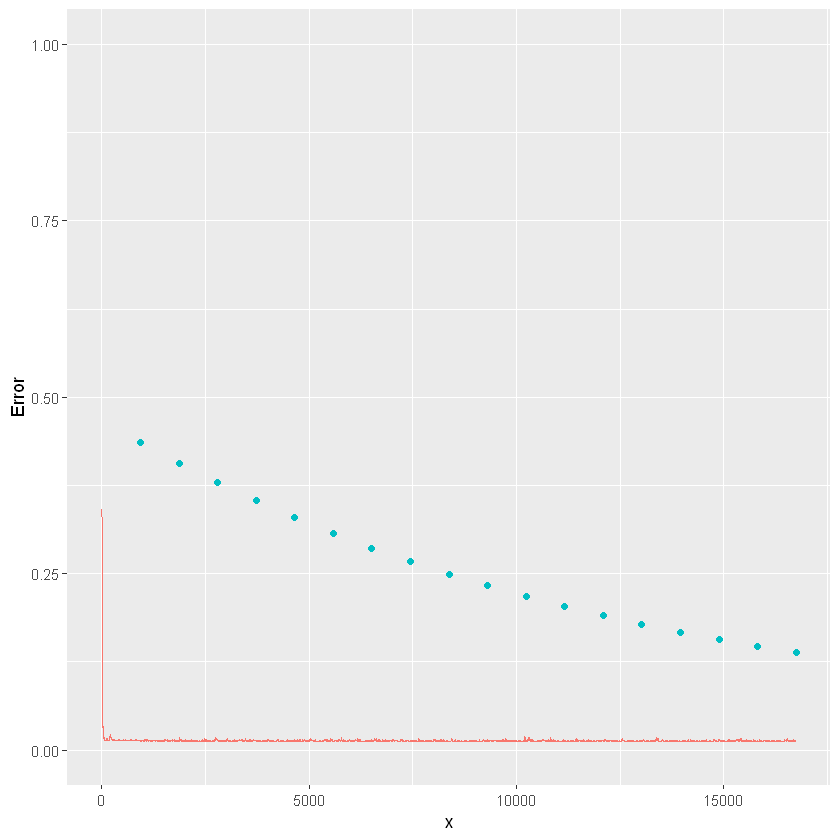

In [56]:
ggplot(data=plotdataframe,aes(x=x,y=SGD))+geom_point(aes(x=plotdataframe$x,y=plotdataframe$BGD,color = 'red'))+geom_line(aes(x=plotdataframe$x,y=plotdataframe$SGD,color= 'blue'))+ylim(0,1)+ylab('Error') + theme(legend.position = "none")


The blue line above represents the error for batch gradient descent and red line represents the error for stochastic gradient descent. From the above graph, we can ascertain that SGD converges much faster in comparison to BGD. This is due to the fact how these algorithms are designed. In SGD, we process each data point at a time while in batch, we process the entire dataset at a time which is computationally more costly. A thing to note though is in fluctuations of the error rate. In BGD, the error rate decreases in a stable fashion in comparison with SGD where there are multiple fluctuations in the error rate since we process each datapoint at a time. This is due to the fact that in sGD, the number of iterations is 18 x N number of times while in BGD, it fluctuates only 18 number of times.

In addition to above, the stochastic gradient descent produces a lower error rate compared to batch gradient descent.